In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 1
LR = 5e-1
EPOCH = 100
criterion = nn.CrossEntropyLoss()

In [10]:
num_classes = 4 # helo 글자 중 맞추는 것

input_size = 4
output_size = 4
hidden_size = 3

idx2char = ['h','e','l','o']
x_data = [0,1,2,2] # he11
one_hot_lookup = torch.eye(4).tolist() # 해당 4글자에 대해 원핫인코딩 해준 것 > [1,0,0,0], [0,1,0,0] ...
print(one_hot_lookup)
print("-"*20)
y_data = [1,2,2,3] # ello
seq_len = 4

x_one_hot = [one_hot_lookup[x] for x in x_data]
print(f"x_one_hot : {x_one_hot}")

[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
--------------------
x_one_hot : [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0]]


In [21]:
X = torch.tensor(x_one_hot).unsqueeze(dim=0) # X.shape = (Data_size, seq_len, input_size)
print(X.shape) # seq_len : 데이터 넣는 부분의 길이 > input의 개수
# input_size : 원핫인코딩 len > input 한 개의 길이
Y = torch.tensor(y_data).reshape(1,-1,1) # Y.shape = (Data_size, seq_len, 1)
print(Y.shape) # 1x4x1 > 1개 라벨 4개, 1

torch.Size([1, 4, 4])
torch.Size([1, 4, 1])


In [11]:
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            x = self.transform(x)
        y = self.Y[idx]
        return x, y

In [12]:
custom_DS = Custom_Dataset(X, Y)
train_DL = torch.utils.data.DataLoader(custom_DS, batch_size = BATCH_SIZE, shuffle = False)

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first=True, nonlinearity ="tanh")
		      # out, h = self.rnn(x, h_init)
          # hidden_size: hidden state의 차원 크기 = len?
            # input_size = 4, hidden_size = 3
        self.fc = nn.Linear(hidden_size, output_size) # y를 만들 때 사용한다
		      # out.shape = (BS,seq_len,hidden_size) = 1, 4, 1?
          # output_size = 4

    def forward(self, x, h_init):
    # x.shape = (BS,seq_len,input_size)
    # h.shape = (Dimension * num_layer, BS, hidden_size)

		# rnn cell 한번씩 통과시켜서 각 hi 를 저장하자
        self.h = []
        out=torch.tensor([])
        hi = h_init
        for j in range(seq_len):
            x_letter = x[:,j,:].unsqueeze(dim=1) # x.shape = (BS,seq_len,input_size) 를 맞춰줌
            # (1,1,4) > 하나씩 넣으니까 seq_len = 1?
            _, hi = self.rnn(x_letter, hi) # y_hat.shape = (BS,seq_len,hidden_size)
            hi.retain_grad() # 그냥 Wx를 구하게 되면 gradient가 합산되기 때문에 gradient가 줄어드는 것을 못 본다
            # 그래서 hi.retain_grad()를 해주는 것
            self.h += [hi]
            out = torch.cat([out, hi.permute(1,0,2)], dim=1) # out.shape = (BS,seq_len,hidden_size)
            # .permite(1,0,2) 는 사실 D*num_layer=1 이라서 가능한거지 엄밀하게는 틀림
        out = self.fc(out) # x.shape = (BS,seq_len,output_size)
        return out

In [14]:
model = RNN(input_size, hidden_size, output_size)
print(model)
x_batch, _ = next(iter(train_DL)) # x.shape = (BS,seq_len,input_size) 를 맞춰줌
h_init = torch.zeros(1, x_batch.shape[0], hidden_size) # h.shape = (D*num_layer, BS, hidden_size) 를 맞춰줌
y_hat = model(x_batch, h_init) # 0 번째 글자

RNN(
  (rnn): RNN(4, 3, batch_first=True)
  (fc): Linear(in_features=3, out_features=4, bias=True)
)


In [15]:
def Train(model, train_DL, criterion, **kwargs):
    optimizer=optim.SGD(model.parameters(), lr = kwargs["LR"])

    NoT=len(train_DL.dataset) # Number of training data
    loss_history = []
    mean_grad_history=torch.tensor([])

    model.train() # train mode로!
    h_init=torch.zeros(1,BATCH_SIZE,hidden_size) # h.shape = (D*num_layer, BS, hidden_size) 를 맞춰줌
    for ep in range(kwargs["EPOCH"]):
        rloss = 0
        rgrad = torch.zeros(seq_len)
        print("predicted string: ", end='')
        for x_batch, y_batch in train_DL:
            # x_batch.shape = (BS, seq_len, input_size)
            # y_batch.shape = (BS, seq_len, 1)
            # grad (batch)
            h_init = torch.zeros(1, x_batch.shape[0], hidden_size)
            y_hat = model(x_batch, h_init) # y_hat.shape = (BS,seq_len,hidden_size)
            L4 = criterion(y_hat[0,-1,:].reshape(1,-1), y_batch[0,-1,:].reshape(-1)) # y_batch는 1D 여야 함
            # 0 번째 data에 대해서만 L4 계산 (멀수록 잊혀지는 현상만 보기 위해)
            L4.backward() # L4에 대해서 미분하고, 각 절대값을 더했다
            rgrad += torch.tensor([model.h[i].grad.abs().sum() * x_batch.shape[0] for i in range(seq_len)])
            # inference
            y_hat = model(x_batch, h_init)
            # cross entropy loss
            loss = 0
            for i in range(x_batch.shape[0]):
                loss += criterion(y_hat[i], y_batch[i].reshape(-1)) # y_batch는 1D 여야 함
                pred = y_hat[i].argmax(dim=1)
                print(*[idx2char[p] for p in pred], sep="")
            # update
            optimizer.zero_grad() # gradient 누적을 막기 위함
            loss.backward() # backpropagation
            optimizer.step() # weight update
            # loss accumulation
            loss_b = loss.item() * x_batch.shape[0] # batch loss # BATCH_SIZE 로 하면 마지막 16개도 32개로 계산해버림
            rloss += loss_b # running loss
        # grad and weight (epoch)
        mean_grad_history = torch.cat([mean_grad_history, rgrad.reshape(1,-1)/NoT], dim=0)
        # 평균울 봤다
        # print loss
        loss_e = rloss/NoT # epoch loss
        loss_history += [loss_e]
        print("Epoch:", ep+1, "train loss:", round(loss_e,5) )
        print("-"*20)
    return loss_history, mean_grad_history

In [16]:
model = RNN(input_size, hidden_size, output_size)
loss_history, mean_grad_history = Train(model, train_DL, criterion,
                                        LR=LR, EPOCH=EPOCH)
# predicted string : hell을 넣었을 때 학습이 어떻게 되는지 보는 것

predicted string: eeee
Epoch: 1 train loss: 1.46034
--------------------
predicted string: elee
Epoch: 2 train loss: 1.26829
--------------------
predicted string: llll
Epoch: 3 train loss: 1.17268
--------------------
predicted string: llll
Epoch: 4 train loss: 1.11668
--------------------
predicted string: llll
Epoch: 5 train loss: 1.0766
--------------------
predicted string: llll
Epoch: 6 train loss: 1.04254
--------------------
predicted string: llll
Epoch: 7 train loss: 1.01044
--------------------
predicted string: llll
Epoch: 8 train loss: 0.97856
--------------------
predicted string: llll
Epoch: 9 train loss: 0.9461
--------------------
predicted string: llll
Epoch: 10 train loss: 0.91267
--------------------
predicted string: elll
Epoch: 11 train loss: 0.87807
--------------------
predicted string: elll
Epoch: 12 train loss: 0.84223
--------------------
predicted string: elll
Epoch: 13 train loss: 0.80515
--------------------
predicted string: elll
Epoch: 14 train loss: 0.76

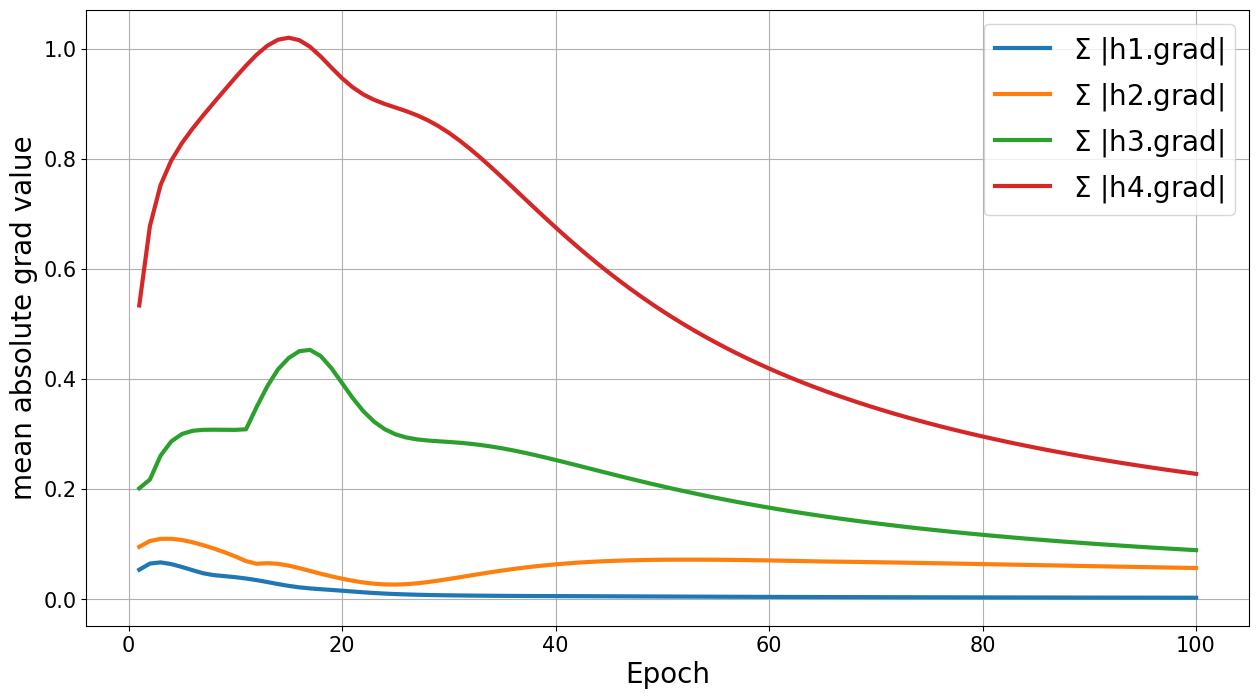

In [17]:
plt.figure(figsize=[15,8])
plt.plot(range(1,EPOCH+1), mean_grad_history[:,0], label = "$\Sigma$ |h1.grad|", linewidth=3)
plt.plot(range(1,EPOCH+1), mean_grad_history[:,1], label = "$\Sigma$ |h2.grad|", linewidth=3)
plt.plot(range(1,EPOCH+1), mean_grad_history[:,2], label = "$\Sigma$ |h3.grad|", linewidth=3)
plt.plot(range(1,EPOCH+1), mean_grad_history[:,3], label = "$\Sigma$ |h4.grad|", linewidth=3)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("mean absolute grad value", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

L4에 대한 미분을 볼 때, h4가 가장 크고, h1은 가장 낮은 것을 확인할 수 있었다